# Data

## Import libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, transformer_estimator,
                              residuals)

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

## Load Data

In [3]:
data = pd.read_csv('data_available/selected_data.csv', sep=',')
data.shape  #### cambiar esto

(7344, 9)

Let's plot feature names to remember them.

In [4]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
#num_features.remove('longitude')
#num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,code
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


We can't feed the models with categorical variables in their current form so we will need to encoder them. We will have a new "variable" for each level of the categorical variables. 

In [5]:
levels_type_house = data.type_house.unique()
levels_code = data.code.unique()
#levels_city_district = data.city_district.unique()

cat_feat_df['n_levels'] = [data.code.nunique(), data.type_house.nunique()]
cat_feat_df['sample'] = [levels_code[:5], levels_type_house]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,code,136,"[nan, W91, Y35, D08, D6W]"
1,type_house,2,"[house, nan, apartment]"


## Split Data

QUITAR LAS VARIABLES AL FINAL DEL NOTEBOOK ANTERIOR

In [6]:
features = [
    'price',
    'floor_area',
#    'views',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
#    'sale_type',
    'type_house',
#    'postcode',
#    'state_district',
#    'county',
#    'city_district',
#    'road',
#    'place',
    'code',
#    'admin1',
#    'cities'
]

data = data[features].copy()
data.shape

(7344, 8)

In [7]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.15, 
                                              output='X_y_train_test',
                                              random_state=7)

X_train: (6242, 7) 
X_test: (1102, 7) 
y_train: (6242,) 
y_test: (1102,) 



# Metrics

We are going to use the following metrics to evaluate the models:

In [8]:
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

Transformations

https://scikit-learn.org/stable/modules/preprocessing.html

# Models

There are several things that must be taken into account when we want to choose the right machine learning algorithm. Some of them are the size of the data, accuracy and/or interpretability of the output, linearity, etc. Also, it is important that the data conform to the assumptions of the model. 

Following the book "Feature Engineering for Machine Learning" from Alice Zheng & Amanda Casari, we are going to take into account some important aspects of the data in order to better understand what kind of transformations we should apply to the data we are working with.

The Magintude of the data
- 

Scale of the features
- For models that use Euclidean Distance it is a good idea is to normalize the features so that the output stays on an expected scale.
- Tree based models couldn't care less.

Distribution of numeric features
- Some models assume that the data are distributed like a Gaussian (Empiric rule and CLT)
- Power transformations (variance-stabilizing transformations) as logarithmic or Cox Box transformations are powerful tools for dealing with heavy-tailed distributions. 



Longitude and latitude are bounded in value, do they need feature scaling?

As we saw in the Data Analysis notebook the Box Cox transformation brings our features close to a Gaussian, so we could use that transformation. 

**The Cutoff Levels**

||Price|floor Area|Views|Bedroom|Bathroom|
|:---:|:---:|:---:|:---:|:---:|:---:|
|**Minimum**|32000.00|1|0.00|1|1|
|**Cutoff Min**|32000.00|40|0.00|1|1|
|**Cutoff Max**|2650000.00|732|46044.00|8|7|
|**Maximun**|10000000.00|10279|125030.00|43|47|

In [9]:
data.sample()

,price,floor_area,latitude,longitude,bedroom,bathroom,type_house,code
6743,900000.0,123,53.322812,-6.237627,3,3,house,D04


## Baseline Model

## Multiple Linear Regression

In [10]:
def transformer_estimator(num_transformation, regressor, poly_degree=1):

    if num_transformation is 'std_scaler':
        num_pipe = Pipeline([
            ('std_scaler', StandardScaler())
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
            ])
    elif num_transformation is 'power_transformer':
        num_pipe = Pipeline([
            ('power_transformer', PowerTransformer(method='yeo-johnson')), #, standardize=False
            ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
            ])    
        

    cat_pipe = Pipeline([
        ('one_hot_encoder', OneHotEncoder(categories=[levels_code, levels_type_house]))  # No hace nada si ya transformadas
                                          #handle_unknown='ignore'
        ])
    # Las transforme antes para evitar problemas no las variables a la hora de predecir e el test_set...

    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_features),
        ('cat', cat_pipe, cat_features),
        ]) #, remainder='passthrough'


    pipe_estimator = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('imputer', SimpleImputer(strategy='constant', # esto lo puedo agnadir en los otros pipes
                                  fill_value=None)),
        ('regressor', regressor)
        ])
    
    return pipe_estimator

In [11]:
lr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                              
                                       regressor=LinearRegression(), 
                                       poly_degree=1)

scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=y_train, 
                                                cv=10, 
                                                return_train_score=False)

r2 mean: 0.6385401038326001
r2 std: 0.0363618933363959 

MAE mean: -114242.50302887018
MAE std: 5834.269903833505 

MAPE mean: -0.36491816038861413
MAPE std: 0.015013071067076713 

RMSE mean: -181991.88719066608
RMSE std: 15073.472728775814 



### Overfitting and Preformance Analysis

We can identify if a machine learning model has overfit by first evaluating the model on the training dataset and then evaluating the same model on a holdout test dataset.

If the performance of the model on the training dataset is significantly better than the performance on the test dataset, then the model may have overfit the training dataset.

In [12]:
lr = lr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = lr.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = lr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6565418947723425
MAE: 111329.76419252346
MAPE: 0.35422605390252876
RMSE: 178186.41943349098

Performance on the test set:
 ----------
R²: 0.6056919434828945
MAE: 106990.12688294591
MAPE: 0.3594920018529949
RMSE: 160136.74861323944



#### Learning Curves

The model is underfitting the training data, so we need to use more complex models or come up with better features.

### Residual Diagnostics

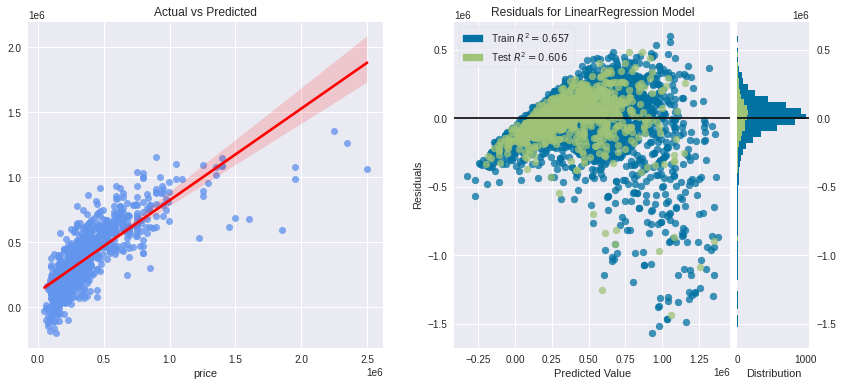

In [13]:
residuals(lr_pipe_estimator, X_train, X_test, y_train, y_test)

## Polynomial Regression

In [14]:
pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                          
                                       regressor=LinearRegression(), 
                                       poly_degree=1)

grid_search = GridSearchCV(estimator=pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 10)}, 
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
#grid_search.best_estimator_

{'preprocessor__num__poly__degree': 3}
0.7475043994942953


In [15]:
#pd.DataFrame(grid_search.cv_results_) # plotearlo

In [16]:
pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                          
                                         regressor=LinearRegression(),
                                       poly_degree=3)

scores = scores_statistics(estimator=pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.7477406475852575
r2 std: 0.032309826035726436 

MAE mean: -94740.95134301903
MAE std: 4526.274954095079 

MAPE mean: -0.27526340820935996
MAPE std: 0.011498338614606751 

RMSE mean: -151783.5130225027
RMSE std: 11768.920107460568 



### Overfitting Analysis

In [17]:
poly = pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = poly.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = poly.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)


Performance on the training set:
 ----------
R²: 0.7716279698936316
MAE: 90819.78253894637
MAPE: 0.26287242234593095
RMSE: 145297.84478598036

Performance on the test set:
 ----------
R²: 0.7406695101479435
MAE: 84580.92759424279
MAPE: 0.2647359471186111
RMSE: 129867.34779392317



#### Learning Curves

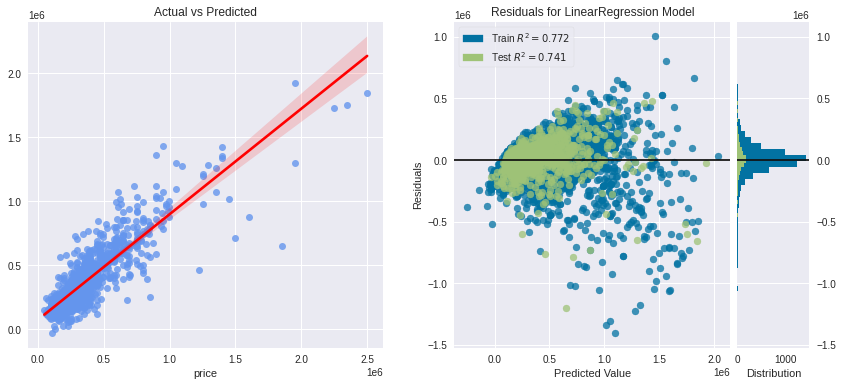

In [19]:
residuals(pipe_estimator, X_train, X_test, y_train, y_test)

## K Nearest Neighbors Regressor

In [121]:
from sklearn.neighbors import KNeighborsRegressor

In [123]:
pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=KNeighborsRegressor(), 
                                       poly_degree=1)

param_grid = [
#    {
 #       'regressor__n_neighbors': [5,10,15,20,25,30,35,40,45,50], 
  #  },
    {
        'preprocessor__num__poly__degree': [1,3],
        'regressor__n_neighbors': [7],  ###########################
        'regressor__weights': ['uniform','distance'], #,'distance'
        'regressor__leaf_size': [30]
    }, 
]

grid_search = GridSearchCV(estimator=pipe_estimator, 
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__num__poly__degree': 1, 'regressor__leaf_size': 30, 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
0.7524463438092918


In [124]:
pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=KNeighborsRegressor(n_neighbors=7,
                                                                     weights='uniform'), 
                                       poly_degree=1)

scores = scores_statistics(estimator=pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7418281398733264
r2 std: 0.018611308789264206 

MAE mean: -89904.822404627
MAE std: 3245.1154521894887 

MAPE mean: -0.24767287366449992
MAPE std: 0.00823181830716877 

RMSE mean: -153997.83834398555
RMSE std: 9876.196137904775 



### Overfitting Analysis

```python
KNeighborsRegressor(n_neighbors=5,  
                    weights='uniform', 
                    algorithm='auto', 
                    leaf_size=30, 
                    p=2, 
                    metric='minkowski', 
                    metric_params=None, 
                    n_jobs=None)
```

In [125]:
knnr = pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = knnr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = knnr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8150594093691621
MAE: 75984.16764315467
MAPE: 0.20857428371887576
RMSE: 130753.65457606062

Performance on the test set:
 ----------
R²: 0.7457128445280258
MAE: 78811.78428830697
MAPE: 0.2275412838229052
RMSE: 128598.34898832208



### Distribucion de los Errores

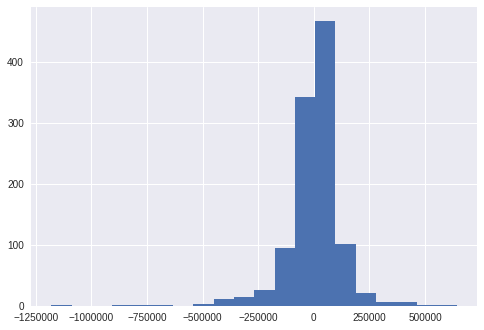

In [126]:
knnr = pipe_estimator.fit(X_train, y_train)
y_pred_test = knnr.predict(X_test)

fig, ax =plt.subplots(1, 1)
ax.hist(y_pred_test - y_test, bins=20); # estamos restando a la prediccion la verdad
# distribucion de los errores
ax.ticklabel_format(style='plain', axis='x')

In [32]:
np.std(y_pred_test - y_test)

150745.24680821932

## Decision Tree Regressor

In [129]:
pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=DecisionTreeRegressor(),
                                       poly_degree=1)

grid_search = GridSearchCV(estimator=pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1,3], #[1,2,3,4],
                               'regressor__max_depth': [6,7,8,9,10], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [12,13,14,15,16,17,18], #range(8, 20),
                               'regressor__min_samples_split': [43], #[2, 43],
                               'regressor__max_leaf_nodes': [68],
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1,
                        #   scoring='neg_mean_squared_error',
                        #   return_train_score=True
                          )

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 3, 'regressor__max_depth': 10, 'regressor__max_leaf_nodes': 68, 'regressor__min_samples_leaf': 15, 'regressor__min_samples_split': 43}
0.7369323993592258


In [95]:
#pd.DataFrame(grid_search.cv_results_)

In [135]:
pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=DecisionTreeRegressor(max_depth=9,
                                                                       min_samples_leaf=16,  #16
                                                                       min_samples_split=43,
                                                                       max_leaf_nodes=68),
                                       poly_degree=3)

scores = scores_statistics(estimator=pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7331814478476076
r2 std: 0.028372689775701898 

MAE mean: -96572.4625943238
MAE std: 3297.1573413373985 

MAPE mean: -0.2835667358527566
MAPE std: 0.010014120352926946 

RMSE mean: -156196.28818747768
RMSE std: 7874.2177010644755 



### Overfitting Analysis

In [136]:
dtr = pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = dtr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = dtr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8008473747585837
MAE: 85552.19462641659
MAPE: 0.26211445584421766
RMSE: 135684.65476892248

Performance on the test set:
 ----------
R²: 0.7177525126625025
MAE: 85736.68112194739
MAPE: 0.2668021321855172
RMSE: 135484.0664780164



### Distribucion de los Errores

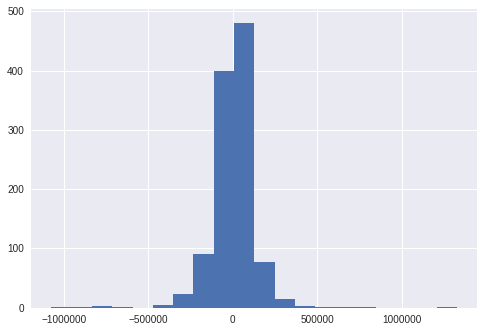

In [137]:
dtr = pipe_estimator.fit(X_train, y_train)
y_pred_test = dtr.predict(X_test)

fig, ax =plt.subplots(1, 1)
ax.hist(y_pred_test - y_test, bins=20); # estamos restando a la prediccion la verdad
# distribucion de los errores
ax.ticklabel_format(style='plain', axis='x')

In [39]:
np.std(y_pred_test - y_test)

141847.0997683639

## Voting Regressor with Basic Algorithms

In [99]:
from sklearn.ensemble import VotingRegressor

In [100]:
scoring_comp = {'r2': 'r2',
                'MAPE': 'neg_mean_absolute_percentage_error'}

Con el random forest mejora un poco pero el rfr sigue siendo mejor

In [139]:
models_r2 = {'poly': 73.41, 'knn': 71.49, 'dt': 73.04}

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.33683582637423143,
 'knn': 0.3280260622189593,
 'dt': 0.33513811140680927}

In [140]:
polyr = transformer_estimator(num_transformation='power_transformer', 
                              regressor=LinearRegression(), 
                              poly_degree=3)
knnr = transformer_estimator(num_transformation='power_transformer', 
                             regressor=KNeighborsRegressor(n_neighbors=7,
                                                           weights='uniform'), 
                             poly_degree=1)
dtr = transformer_estimator(num_transformation='power_transformer', 
                            regressor=DecisionTreeRegressor(max_depth=9,
                                                            min_samples_leaf=16,  #16
                                                            min_samples_split=43,
                                                            max_leaf_nodes=68),
                            poly_degree=3)

voting_reg = VotingRegressor(
    estimators= [('poly', polyr),('knn', knnr),('dt', dtr)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'K Nearest Neighbors Regressor': knnr, 
               'Decission Tree Regressor': dtr, 
             #  'Random Forest Regressor': rfr,
               'Voting Regressor': voting_reg}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7477406278774177
MAPE mean: -0.2752633944219248
----------
K Nearest Neighbors Regressor
r2 mean: 0.742996312910319
MAPE mean: -0.2463997356120617
----------
Decission Tree Regressor
r2 mean: 0.735067030803128
MAPE mean: -0.28139453120598595
----------
Voting Regressor
r2 mean: 0.7957129451377274
MAPE mean: -0.23190572621127528
----------


In [141]:
voting_reg.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_reg.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_reg.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8401053188786644
MAE: 73256.82498370217
MAPE: 0.21166046659606494
RMSE: 121577.92439973805

Performance on the test set:
 ----------
R²: 0.7962897430082039
MAE: 72195.74720817365
MAPE: 0.22227676940381616
RMSE: 115101.14115730893



## Bagging with Polynomial Regression

In [143]:
from sklearn.ensemble import BaggingRegressor

In [144]:
bag_regression = BaggingRegressor(
    
    base_estimator=LinearRegression(),
    n_estimators=500, 
    max_samples=3000, 
#    max_features=50, 
#    bootstrap=True, 
#    bootstrap_features=False, 
#    oob_score=True, 
#    warm_start=False, 
    n_jobs=-1, 
    random_state=42, 
#    verbose=0
)

'''
    base_estimator=LinearRegression(),
    n_estimators=500, 
    max_samples=2000, 
#    max_features=1.0, 
#    bootstrap=True, 
#    bootstrap_features=False, 
#    oob_score=True, 
#    warm_start=False, 
    n_jobs=-1, 
    random_state=42, 
#    verbose=0
----------------
R²: 0.7724293692138182
R²: 0.7353834187513661
'''

'\n    base_estimator=LinearRegression(),\n    n_estimators=500, \n    max_samples=2000, \n#    max_features=1.0, \n#    bootstrap=True, \n#    bootstrap_features=False, \n#    oob_score=True, \n#    warm_start=False, \n    n_jobs=-1, \n    random_state=42, \n#    verbose=0\n----------------\nR²: 0.7724293692138182\nR²: 0.7353834187513661\n'

In [171]:
bag_poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=bag_regression, 
                                       poly_degree=3)

scores = scores_statistics(estimator=bag_poly_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7466659406013886
r2 std: 0.016944771320615285 

MAE mean: -95318.31887764904
MAE std: 2816.7350285341413 

MAPE mean: -0.27773746805763644
MAPE std: 0.009304170112419215 

RMSE mean: -152483.7050849386
RMSE std: 7757.79636076238 



In [147]:
bag_reg = bag_poly_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = bag_reg.predict(X_train)
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = bag_reg.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.7710889141564048
MAE: 90983.37902115498
MAPE: 0.2637427368344847
RMSE: 145469.22626370302

Performance on the test set:
 ----------
R²: 0.7406412443524848
MAE: 84531.85683341564
MAPE: 0.2642208070554524
RMSE: 129874.42506407372



## Random Forest Regressor

In [ ]:
#pd.DataFrame(grid_search.cv_results_).tail()

In [170]:
rfr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=RandomForestRegressor(
                                                      n_estimators=320, 
                                              #        max_depth=9,  # 9
                                               #       min_samples_split=20,  # 43
                                                #      min_samples_leaf=16,   #16
                                                 #     max_leaf_nodes=68,   #68
                                                      n_jobs=-1), 
                                       poly_degree=1)

scores = scores_statistics(estimator=rfr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.8167379127041533
r2 std: 0.0247462822520955 

MAE mean: -74994.58602624404
MAE std: 3414.9526905681064 

MAPE mean: -0.211879490341008
MAPE std: 0.007395139167502591 

RMSE mean: -129428.68771850066
RMSE std: 10036.62715182907 



In [151]:
rfr = rfr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = rfr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = rfr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9752638990090787
MAE: 27243.564228116753
MAPE: 0.07695016020719202
RMSE: 47819.31369595795

Performance on the test set:
 ----------
R²: 0.8022839727084141
MAE: 65359.69656846858
MAPE: 0.19610825651797534
RMSE: 113395.05575410472



The model is overfitting the training data. Necesitamos regularizar!!

## Extremely Randomized Trees

In [53]:
from sklearn.ensemble import ExtraTreesRegressor

In [54]:
etr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=ExtraTreesRegressor(n_estimators=100, 
                                                                     max_depth=None, 
                                                                     min_samples_split=2, 
                                                                     min_samples_leaf=1, 
                                                                     min_weight_fraction_leaf=0.0, 
                                                                     max_features='auto', 
                                                                     max_leaf_nodes=None, 
                                                                     min_impurity_decrease=0.0, 
                                                                     bootstrap=False, 
                                                                     oob_score=False, 
                                                                     n_jobs=-1, 
                                                                     random_state=None, 
                                                                     verbose=0, 
                                                                     warm_start=False, 
                                                                     ccp_alpha=0.0, 
                                                                     max_samples=None), 
                                       poly_degree=1)

scores = scores_statistics(estimator=etr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.7987142666074785
r2 std: 0.035184048933931636 

MAE mean: -77522.11259743333
MAE std: 3806.1322204644243 

MAPE mean: -0.21541244375802293
MAPE std: 0.007993268687988667 

RMSE mean: -135259.1036606323
RMSE std: 12648.181006872166 



In [55]:
etr = etr_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = etr.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = etr.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9998439992922274
MAE: 106.55238705543096
MAPE: 0.0001628800565987213
RMSE: 3797.5281383487845

Performance on the test set:
 ----------
R²: 0.7849289574853389
MAE: 68855.48098911071
MAPE: 0.2033826941190739
RMSE: 118267.15541986255



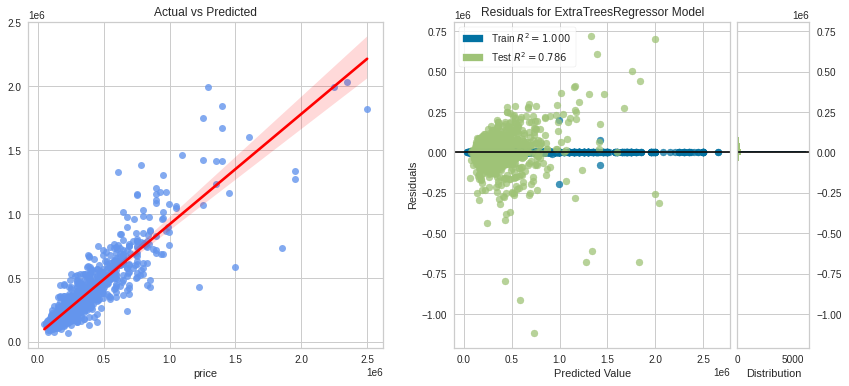

In [68]:
def residuals(estimator, X_train, X_test, y_train, y_test):

    fig, ax =plt.subplots(1,2,figsize=(14,6))

    sns.regplot(x=y_test, y=estimator.fit(X_train, y_train).predict(X_test), 
                scatter_kws={"color": "cornflowerblue"}, line_kws={"color": "red"}, ax=ax[0])\
               .set_title('Actual vs Predicted')

    visualizer = ResidualsPlot(estimator, ax=ax[1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show();
    
residuals(etr_pipe_estimator, X_train, X_test, y_train, y_test)

## AdaBoost

In [158]:
from sklearn.ensemble import AdaBoostRegressor

In [160]:
pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=AdaBoostRegressor(base_estimator=None, 
                                                                   n_estimators=3, 
                                                                   learning_rate=1.0, 
                                                                   loss='linear', 
                                                                   random_state=42), 
                                       poly_degree=1)

scores = scores_statistics(estimator=pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.6087111797331102
r2 std: 0.04381340847533776 

MAE mean: -124239.51266233542
MAE std: 5199.447956531263 

MAPE mean: -0.40192079821847726
MAPE std: 0.015902904767572827 

RMSE mean: -189105.7788374017
RMSE std: 14474.746715075167 



In [161]:
adaboost = pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = adaboost.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = adaboost.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.6496616334989983
MAE: 121953.28611895665
MAPE: 0.39926011871918493
RMSE: 179962.31304278632

Performance on the test set:
 ----------
R²: 0.5863296801050738
MAE: 110892.0045826529
MAPE: 0.38014765838014686
RMSE: 164021.34247290366



## Gradient Boosting Regressor

In [162]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gb_pipe_est = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', 
                              fill_value=None)),
    ('regressor', AdaBoostRegressor(base_estimator=None, 
                              #      *, 
                                    n_estimators=3, 
                                    learning_rate=1.0, 
                                    loss='linear', 
                                    random_state=42))
                           ])
gb_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=AdaBoostRegressor(base_estimator=None, 
                                                                   n_estimators=3, 
                                                                   learning_rate=1.0, 
                                                                   loss='linear', 
                                                                   random_state=42), 
                                       poly_degree=1)

scores = scores_statistics(estimator=gb_pipe_est, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

In [ ]:
gboost = gb_pipe_est.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = gboost.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = gboost.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

## Extreme Gradient Boosting

In [164]:
from xgboost import XGBRegressor

In [202]:
xgb_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                       regressor=XGBRegressor(n_estimators= 105), 
                                       poly_degree=1)

scores = scores_statistics(estimator=xgb_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.8156261612493475
r2 std: 0.04096074483664341 

MAE mean: -75472.35727565104
MAE std: 3983.1304498350905 

MAPE mean: -0.21142660774858588
MAPE std: 0.008916689870084867 

RMSE mean: -128976.76948800625
RMSE std: 11850.054757381997 



In [166]:
xgb = xgb_pipe_estimator.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = xgb.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = xgb.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9566673253316019
MAE: 43095.73254953841
MAPE: 0.13845925600346715
RMSE: 63291.511041600905

Performance on the test set:
 ----------
R²: 0.8062390595590501
MAE: 66075.18432395645
MAPE: 0.19430881134359762
RMSE: 112255.15604881509



## Voting Regressor with Ensemble Methods

In [172]:
models_r2 = {'poly': 73.41, 'rfr': 80.92, 'etr': 81.75, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'poly': 0.23231012658227848,
 'rfr': 0.2560759493670886,
 'etr': 0.2587025316455696,
 'xgb': 0.2529113924050633}

In [174]:
polyr = poly_pipe_estimator
rfr = rfr_pipe_estimator
etr = etr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor = VotingRegressor(
    estimators= [('poly', polyr),
                 ('rf', rfr),
                 ('et', etr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'Extra Trees Regressor': etr,
               'XGBoost': egb,
               'Voting Regressor': voting_regressor}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression


/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


r2 mean: 0.7292553071146599
MAPE mean: -0.2794610181293449
----------
Random Forest Regressor
r2 mean: 0.8175478662677577
MAPE mean: -0.20973263653327173
----------
Extra Trees Regressor
r2 mean: 0.798224519502141
MAPE mean: -0.21580515230414204
----------
XGBoost
r2 mean: 0.8156261612493475
MAPE mean: -0.21142660774858588
----------
Voting Regressor


/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


r2 mean: 0.8238246608724588
MAPE mean: -0.20698566826837733
----------


In [175]:
voting_regressor.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Performance on the training set:
 ----------
R²: 0.964680196401373
MAE: 36433.18227696468
MAPE: 0.1068311627272619
RMSE: 57140.87100748259

Performance on the test set:
 ----------
R²: 0.8165362270037648
MAE: 65381.343107356945
MAPE: 0.1968170093883336
RMSE: 109231.61163896728



Y si en lugar de usar el Polynomial Regression usamos el Voting Regressor with Basic Algorithms?

In [176]:
models_r2 = {'voting_reg': 77.81, 'rfr': 80.92, 'etr': 81.75, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'voting_reg': 0.24285268414481895,
 'rfr': 0.2525593008739076,
 'etr': 0.2551498127340824,
 'xgb': 0.249438202247191}

In [178]:
voting_reg = voting_reg
rfr = rfr_pipe_estimator
etr = etr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor = VotingRegressor(
    estimators= [('voting_reg', voting_reg),
                 ('rf', rfr),
                 ('et', etr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_reg, 
               'Random Forest Regressor': rfr, 
               'Extra Trees Regressor': etr,
               'XGBoost': egb,
               'Voting Regressor': voting_reg}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7956753642729896
MAPE mean: -0.23194382501195018
----------
Random Forest Regressor
r2 mean: 0.8176598013688274
MAPE mean: -0.20995311541832015
----------
Extra Trees Regressor
r2 mean: 0.7970490296865991
MAPE mean: -0.21597581613147304
----------
XGBoost
r2 mean: 0.8156261612493475
MAPE mean: -0.21142660774858588
----------
Voting Regressor
r2 mean: 0.7966976913460638
MAPE mean: -0.23195671096666287
----------


In [179]:
voting_regressor.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9691868258550684
MAE: 33685.33596996932
MAPE: 0.10039493845119629
RMSE: 53371.073144901224

Performance on the test set:
 ----------
R²: 0.8222912626777459
MAE: 63691.12128584188
MAPE: 0.19228141583224917
RMSE: 107504.72971213194



y sin ninguno?

In [180]:
models_r2 = {'rfr': 80.92, 'etr': 81.75, 'xgb': 79.92} # estoy usando las del train set, no las del test set com antes 

tot = 0
for key in models_r2:
    tot += models_r2[key]

models_weigth = {}
models_weigth_list = []
for key in models_r2:
    weight = models_r2[key] / tot
    models_weigth[key] = weight
    models_weigth_list.append(weight)
models_weigth
#models_weigth_list

{'rfr': 0.33356692361597756,
 'etr': 0.3369883342264726,
 'xgb': 0.32944474215754976}

In [181]:
#polyr = poly_pipe_estimator
rfr = rfr_pipe_estimator
etr = etr_pipe_estimator
egb = xgb_pipe_estimator

voting_regressor = VotingRegressor(
    estimators= [#('poly', polyr),
                 ('rf', rfr),
                 ('et', etr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {#'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'Extra Trees Regressor': etr,
               'XGBoost': egb,
               'Voting Regressor': voting_regressor}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Random Forest Regressor
r2 mean: 0.8167477210903786
MAPE mean: -0.21011218623619468
----------
Extra Trees Regressor
r2 mean: 0.7975131710911019
MAPE mean: -0.21564048564833027
----------
XGBoost
r2 mean: 0.8156261612493475
MAPE mean: -0.21142660774858588
----------
Voting Regressor
r2 mean: 0.8233064381646192
MAPE mean: -0.20409000225835855
----------


In [182]:
voting_regressor.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = voting_regressor.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = voting_regressor.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.9868713041737208
MAE: 22709.98010484902
MAPE: 0.06940786379074693
RMSE: 34837.62254206547

Performance on the test set:
 ----------
R²: 0.8124247745799787
MAE: 63383.72281259873
MAPE: 0.1889940345387361
RMSE: 110448.77911461078



## Stacking

Regression Meta-Model: Linear Reagression

In [183]:
from sklearn.ensemble import StackingRegressor

In [184]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('polyr', poly_pipe_estimator))
    level0.append(('rfr', rfr_pipe_estimator))
    level0.append(('etr', etr_pipe_estimator))
    level0.append(('egb', xgb_pipe_estimator))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [185]:
models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'Random Forest Regressor': rfr_pipe_estimator, 
               'Extra Trees Regressor': etr_pipe_estimator,
               'XGBoost': xgb_pipe_estimator,
               'Stacking': get_stacking()}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=y_train, 
                            cv=10, 
                            return_train_score=False)

Polynomial Regression


/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


r2 mean: 0.7292553071146599
MAPE mean: -0.2794610181293449
----------
Random Forest Regressor
r2 mean: 0.8166531128534398
MAPE mean: -0.21001840868639082
----------
Extra Trees Regressor
r2 mean: 0.7969873481920722
MAPE mean: -0.21564934280914416
----------
XGBoost
r2 mean: 0.8156261612493475
MAPE mean: -0.21142660774858588
----------
Stacking


/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/javi

r2 mean: 0.8267567044474291
MAPE mean: -0.20277536728385898
----------


In [ ]:
stacking = get_stacking()
stacking.fit(X_train, y_train)

print('Performance on the training set:\n', '-'*10)
y_pred_train = stacking.predict(X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = stacking.predict(X_test)
metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

# Dataset to try the frontend:

In [186]:
X_test.shape, y_test.shape, y_pred.shape

((1102, 7), (1102,), (1102,))

In [187]:
X_test.sample()

,floor_area,latitude,longitude,bedroom,bathroom,type_house,code
2568,171,52.146575,-8.396217,4,4,house,NaN


In [188]:
y_test.sample()

3227    239000.0
Name: price, dtype: float64

In [189]:
y_pred = pd.Series(y_pred.copy())
y_pred.sample()

868    166708.027686
dtype: float64

In [190]:
X_test.isna().sum()

floor_area      0
latitude        0
longitude       0
bedroom         0
bathroom        0
type_house     72
code          204
dtype: int64

In [191]:
y_test.isna().sum()

0

In [192]:
y_pred.isna().sum()

0

In [193]:
y_pred.head(5)

0    228848.401763
1    915228.133002
2    412512.472691
3    476934.844831
4    473529.082650
dtype: float64

In [194]:
X_test.head()

,floor_area,latitude,longitude,bedroom,bathroom,type_house,code
2680,91,52.011200,-8.610169,3,3,house,NaN
5903,390,51.846032,-8.337456,6,5,house,T12
5822,105,53.286689,-6.340968,3,1,house,D24
1514,148,53.446994,-6.251214,3,4,house,K67
1350,74,53.275541,-6.094164,1,1,apartment,A96


In [195]:
y_test.head()

2680    250000.0
5903    990000.0
5822    350000.0
1514    465000.0
1350    450000.0
Name: price, dtype: float64

In [201]:
data.columns

Index(['price', 'floor_area', 'latitude', 'longitude', 'bedroom', 'bathroom',
       'type_house', 'code'],
      dtype='object')

In [208]:
X = data[['floor_area', 'latitude', 'longitude', 
          'bedroom', 'bathroom', 'type_house', 'code']].copy()
y = data['price']

#data_to_frontend = X.copy()
#data_to_frontend['price'] = y.copy()

data_to_frontend = data.copy()
xgb = xgb_pipe_estimator.fit(X_train, y_train)

y_pred = xgb.predict(X)

data_to_frontend['inferred_price'] = list(y_pred) # me daba muchos nan si lo unia siendo una series
data_to_frontend['difference'] = data_to_frontend.inferred_price - data_to_frontend.price
data_to_frontend.sample()

,price,floor_area,latitude,longitude,bedroom,bathroom,type_house,code,inferred_price,difference
2306,295000.0,68,53.364192,-6.245409,2,2,apartment,D09,312881.96875,17881.96875


In [209]:
data_to_frontend.isna().sum()

price                0
floor_area           0
latitude             0
longitude            0
bedroom              0
bathroom             0
type_house         471
code              1263
inferred_price       0
difference           0
dtype: int64

In [210]:
data_to_frontend.difference.head()

0    84772.43750
1      660.71875
2   -40700.59375
3    -4232.12500
4    44582.09375
Name: difference, dtype: float64

In [212]:
print(data_to_frontend.difference.min())
print(data_to_frontend.difference.max())    
print(data_to_frontend.difference.mean())    

-1290942.3125
634161.625
1011.3849395552492


In [213]:
print(data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].max())
print(data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].min())

634161.625
12.46875


In [214]:
print(data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].max())
print(data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].min())

-29.09375
-1290942.3125


In [217]:
nan_array = np.empty(data_to_frontend.shape[0])
nan_array[:] = np.NaN
nan_ser = pd.Series(nan_array)
nan_ser.shape

(7344,)

In [218]:
data_to_frontend['dif_per'] = nan_ser
data_to_frontend.sample()

,price,floor_area,latitude,longitude,bedroom,bathroom,type_house,code,inferred_price,difference,dif_per
60,309000.0,110,51.822164,-8.230662,3,3,house,P25,286741.6875,-22258.3125,NaN


In [219]:
max_pos = data_to_frontend.loc[data_to_frontend.difference > 0, 'difference'].max()
max_neg = data_to_frontend.loc[data_to_frontend.difference < 0, 'difference'].min()

def difference_percentage(dif):
    
    if dif > 0:
        result = dif / max_pos
    elif dif < 0:
        result = -(dif / max_neg)
        
    return result

In [220]:
for i, row in data_to_frontend.iterrows():
    #print(row.difference)
    
    dif_per = difference_percentage(row.difference)
        
    data_to_frontend.loc[i, 'dif_per'] = dif_per
    

In [221]:
data_to_frontend.sample()

,price,floor_area,latitude,longitude,bedroom,bathroom,type_house,code,inferred_price,difference,dif_per
2895,330000.0,170,52.260466,-6.389327,3,4,house,Y35,384707.8125,54707.8125,0.086268


In [222]:
data_to_frontend.isna().sum()

price                0
floor_area           0
latitude             0
longitude            0
bedroom              0
bathroom             0
type_house         471
code              1263
inferred_price       0
difference           0
dif_per              0
dtype: int64

In [223]:
data_to_frontend.to_csv('FrontEnd/data_predicted.csv', sep=',', index=False)